목차:

```
Step 0. 전략
Step 1. 데이터 불러오기
Step 2. 장기 보유 성과 확인
Step 3. 장단기 이동평균 그래프 확인
Step 4. 보유 구간 표기
Step 5. 매매 시점 표기
Step 6. 전략 수익률 계산
```

## Step 0. 전략

과거에 카카오 상장 초기에 배팅했다면 지금쯤 소위 대박을 터뜨렸을 것입니다. 이를 아는 상황에서 과연 특정 (차트) 매매 전략이 단순 장기 보유보다 우세한지 확인해 보고자 합니다.

전략은 잘 알려진 골든크로스 매수, 데드크로스 매도 방식을 시도합니다. 골든크로스는 단기 이동평균선(보통 20일 이하)이 장기 이동평균선(보통 30일 이상)을 뚫고 올라가는 시점, 데드크로스는 그 반대 시점을 지칭합니다.

여기에 모멘텀을 더해 상승 추세의 골든크로스를 매수 포인트로 잡을 수도 있지만, 논의를 단순화하기 위해 이 부분은 고려하지 않습니다.

예상컨데 엄청난 돈이 되었을 것이다. 그런데 정확히 얼마가 되었을 지 궁금하지 않은가? 이러한 작은 고민에서도 가설 검정을 시작해볼 수 있다.

## Step 1. 데이터 불러오기

먼저 우리가 사용할 라이브러리는 다음과 같습니다.

1. 데이터 확보를 위해 금융 데이터를 편하게 가져올 수 있는 `FinanceDataReader`를 사용합니다.
2. 데이터프레임이라는 파이썬 자료형을 편하게 다루기 위해 `pandas`를 사용합니다. 
3. 마지막으로 시각화를 위해 `matplotlib`과 `seaborn`패키지를 사용합니다. 
4. 주피터노트북에서 종종 나타나는 불필요한 경고를 숨기기 위해 `warnings`패키지도 사용하겠습니다.(치명적이라면 경고가 아니라 에러가 바로 뜨고 코드가 실행되지 않으니 걱정하지 않으셔도 됩니다)



In [62]:
import FinanceDataReader as fdr

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['classic']) # 테마: 주식 차트 느낌내기

import warnings
warnings.filterwarnings(action='ignore')

이제 `FinanceDataReader` 패키지로 데이터를 불러옵니다.


In [63]:
stock_kakao = fdr.DataReader('035720')
stock_kakao

Open   High    Low  Close   Volume    Change
Date                                                     
1999-11-11    999    999    999    999       12       NaN
1999-11-12   1115   1115   1115   1115      140  0.116116
1999-11-15   1249   1249   1249   1249      405  0.120179
1999-11-16   1396   1396   1396   1396      214  0.117694
1999-11-17   1561   1561   1561   1561      191  0.118195
...           ...    ...    ...    ...      ...       ...
2022-06-09  81100  81800  80300  81300  1732196 -0.002454
2022-06-10  80400  81000  80000  80100  1430382 -0.014760
2022-06-13  77800  78200  76100  76500  2176053 -0.044944
2022-06-14  74900  76900  74200  76600  2342617  0.001307
2022-06-15  76100  76500  72100  72700  2844798 -0.050914

[5576 rows x 6 columns]

## Step 2. 장기 보유 성과 확인

1999년 11월 11일에 카카오 주식을 100만원치 샀다고 가정하면 현재 주가 기준으로 약 7천만 원이 되었습니다.

작년까지만 해도 주가가 15만 원을 상회했기 때문에 이는 사실 반 토막 난 가격입니다. 그럼에도 불구하고 70배 이상 수익을 본 것입니다.

In [64]:
# 오타 방지를 위해 컬럼명 소문자로 변경
stock_kakao.columns = stock_kakao.columns.str.lower()
stock_kakao.columns

Index(['open', 'high', 'low', 'close', 'volume', 'change'], dtype='object')

In [65]:
# 수익 계산을 위해 첫날 주가로 전체 종가 나누기 
stock_kakao['yield'] = stock_kakao['close']/stock_kakao['close'][0]

# 첫날 매입한 카카오 주식의 총 가격을 100만원으로 환산
stock_kakao['yield'] *= 1000000

# 소수점 이하 제거
stock_kakao['yield'] = stock_kakao['yield'].astype('int64')
stock_kakao['yield']

# 보기 쉽게 '천' 단위 구분자 포함된 문자열로 변환
# ## ex) 1.000000e+06 --> "1,000,000.0"
stock_kakao['yield'] = stock_kakao['yield'].apply(lambda x : '{:,}'.format(x))
stock_kakao['yield']

Date
1999-11-11     1,000,000
1999-11-12     1,116,116
1999-11-15     1,250,250
1999-11-16     1,397,397
1999-11-17     1,562,562
                 ...    
2022-06-09    81,381,381
2022-06-10    80,180,180
2022-06-13    76,576,576
2022-06-14    76,676,676
2022-06-15    72,772,772
Name: yield, Length: 5576, dtype: object

전체 기간 주가 흐름입니다.

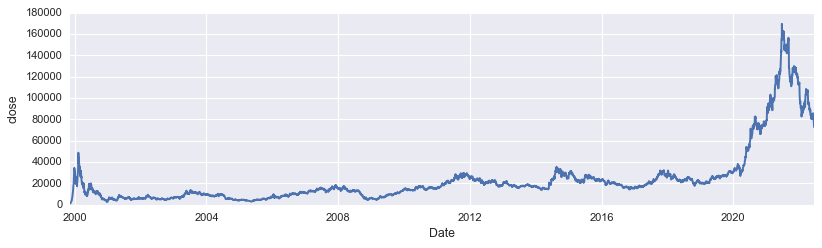

In [66]:
plt.style.use('seaborn')


plt.figure(figsize=(12,3))
sns.lineplot(x=stock_kakao.index, y=stock_kakao['close']);


## Step 3. 장단기 이동평균 그래프 확인

전략은 이동평균 데이터를 사용합니다. 이동평균은 rolling() 함수로 쉽게 구현이 가능합니다.

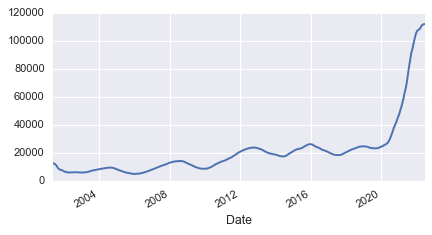

In [67]:
# 그래프 가로로 길게 수정
plt.figure(figsize=(6,3))

# 1년 이동평균 데이터 확보
kakao_moving_avg_365 = stock_kakao['close'].rolling(window=365).mean()

# 1년 이동평균 데이터는 지난 365일간 주가를 평균낸 데이터다.
# 따라서 가장 앞의 364일치 데이터는 NaN으로 처리된다.
# 그래프를 그리기 위해 NaN값을 제거한다.
kakao_moving_avg_365 = kakao_moving_avg_365.dropna()

# 365일 이평선을 그린다
kakao_moving_avg_365.plot();


## (거래가 열리지 않는 날이 있기 때문에 실제로 365일은 아닙니다.)

이제 전략 구현을 위해 단기(5일), 장기(30일) 이동평균을 구합니다.

In [68]:
# 5일 이동평균 데이터(단기)
stock_kakao['short_window'] = stock_kakao['close'].rolling(5).mean()
# 30일 이동평균 데이터(장기)
stock_kakao['long_window'] = stock_kakao['close'].rolling(30).mean()

# 이동평균 데이터가 존재하지 않으면 매매할 수 없기 때문에(전략상) 데이터가 없으면(최초 30일 미만) 제거한다.
stock_kakao.dropna(inplace=True)

# 이동평균 데이터(장기) -> 평균이므로 소수점 이하 생김 -> int형으로 변환해서 소수점 제거
stock_kakao['short_window'] = stock_kakao['short_window'].astype('int64')
stock_kakao['long_window'] = stock_kakao['long_window'].astype('int64')

stock_kakao

open   high    low  close   volume    change       yield  \
Date                                                                    
1999-12-22  20522  21950  20522  21950   504048  0.118186  21,971,971   
1999-12-23  24583  24583  23735  24583   137005  0.119954  24,607,607   
1999-12-24  24493  27527  23199  27527   306559  0.119758  27,554,554   
1999-12-27  27215  30829  26635  30829   363146  0.119955  30,859,859   
1999-12-28  32613  34487  31765  34487   179437  0.118655  34,521,521   
...           ...    ...    ...    ...      ...       ...         ...   
2022-06-09  81100  81800  80300  81300  1732196 -0.002454  81,381,381   
2022-06-10  80400  81000  80000  80100  1430382 -0.014760  80,180,180   
2022-06-13  77800  78200  76100  76500  2176053 -0.044944  76,576,576   
2022-06-14  74900  76900  74200  76600  2342617  0.001307  76,676,676   
2022-06-15  76100  76500  72100  72700  2844798 -0.050914  72,772,772   

            short_window  long_window  
Date                                   
1999-12-22         18952         7519  
1999-12-23         20567         8305  
1999-12-24         22610         9185  
1999-12-27         24903        10171  
1999-12-28         27875        11274  
...                  ...          ...  
2022-06-09         82820        84183  
2022-06-10         82100        83846  
2022-06-13         80260        83450  
2022-06-14         79200        83026  
2022-06-15         77440        82453  

[5547 rows x 9 columns]

change 컬럼(등락율)의 숫자가 길어서 보기가 좋지 않습니다. 보기 쉽게 소수점 이하 2자리까지만 남깁니다.

In [69]:
stock_kakao['change'] = stock_kakao['change'].apply(lambda x : '{:.2f}'.format(x))
stock_kakao

open   high    low  close   volume change       yield  \
Date                                                                 
1999-12-22  20522  21950  20522  21950   504048   0.12  21,971,971   
1999-12-23  24583  24583  23735  24583   137005   0.12  24,607,607   
1999-12-24  24493  27527  23199  27527   306559   0.12  27,554,554   
1999-12-27  27215  30829  26635  30829   363146   0.12  30,859,859   
1999-12-28  32613  34487  31765  34487   179437   0.12  34,521,521   
...           ...    ...    ...    ...      ...    ...         ...   
2022-06-09  81100  81800  80300  81300  1732196  -0.00  81,381,381   
2022-06-10  80400  81000  80000  80100  1430382  -0.01  80,180,180   
2022-06-13  77800  78200  76100  76500  2176053  -0.04  76,576,576   
2022-06-14  74900  76900  74200  76600  2342617   0.00  76,676,676   
2022-06-15  76100  76500  72100  72700  2844798  -0.05  72,772,772   

            short_window  long_window  
Date                                   
1999-12-22         18952         7519  
1999-12-23         20567         8305  
1999-12-24         22610         9185  
1999-12-27         24903        10171  
1999-12-28         27875        11274  
...                  ...          ...  
2022-06-09         82820        84183  
2022-06-10         82100        83846  
2022-06-13         80260        83450  
2022-06-14         79200        83026  
2022-06-15         77440        82453  

[5547 rows x 9 columns]

두 이동평균 그래프를 함께 그리면 다음과 같습니다.

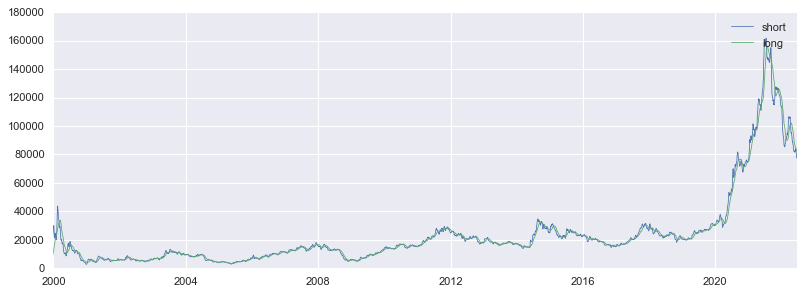

In [70]:
plt.figure(figsize=(12,4))

plt.plot(stock_kakao.loc[:,'short_window'], label='short', linewidth=0.7)
plt.plot(stock_kakao.loc[:,'long_window'], label='long', linewidth=0.7)

plt.legend()
plt.show()

잘 보이지 않으니 2022년 그래프만 확대해 봅니다.

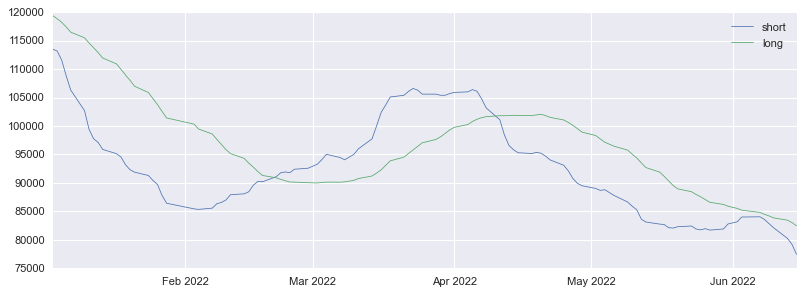

In [71]:
plt.figure(figsize=(12,4))

plt.plot(stock_kakao.loc['2022':,'short_window'], label='short', linewidth=0.7)
plt.plot(stock_kakao.loc['2022':,'long_window'], label='long', linewidth=0.7)

plt.legend()
plt.show()

이렇게 기존 데이터 테이블에 단기 이동평균 데이터와 장기 이동평균 데이터를 추가했습니다. 이제 각 날짜(인덱스) 별로 short_window가 long_window를 역전 상승하는 지점에서 '종가'(close)에 매수하고, short_window가 long_window를 역전 하강하는 지점에서 '종가'(close)에 매도할 것입니다. 즉, 위 차트에서 파란색 선이 초록색 선을 넘은 가운데 기간만 주식을 보유합니다.

## Step 4. 보유 구간 표기

주식을 들고 있을 구간과 그렇지 않은 구간을 마킹해줍니다.

In [72]:
overs = stock_kakao['short_window'] > stock_kakao['long_window']
overs

Date
1999-12-22     True
1999-12-23     True
1999-12-24     True
1999-12-27     True
1999-12-28     True
              ...  
2022-06-09    False
2022-06-10    False
2022-06-13    False
2022-06-14    False
2022-06-15    False
Length: 5547, dtype: bool

우리는 해당 날짜의 단기 이동 평균이 장기 이동 평균을 넘어서는 순간 매수할 것입니다. 그리고 그 반대가 될 때 매도해야 합니다. 위 데이터를 보면 1999년 12월 22일부터 단기 이동평균이 장기 이동평균을 넘어서 있습니다. 이런 경우는 매수 포인트에 해당하지 않습니다. 우리는 False에서 True로 바뀌는 순간 매수하고, True에서 False로 바뀌는 순간 매도합니다.


표기는 0과 1로 바꿔줄 것입니다. 0과 1을 사용해 주식을 들고 있을(파란색 선> 초록색 선) 구간을 1로, 그렇지 않은 나머지 구간을 0으로 표기합니다. 자료형을 int로 바꿔주면 알아서 숫자로 변환됩니다.

In [73]:
overs = overs.astype('int64')
overs

Date
1999-12-22    1
1999-12-23    1
1999-12-24    1
1999-12-27    1
1999-12-28    1
             ..
2022-06-09    0
2022-06-10    0
2022-06-13    0
2022-06-14    0
2022-06-15    0
Length: 5547, dtype: int64

데이터를 stock_kakao 데이터프레임에 추가합니다.

In [74]:
stock_kakao['overs'] = overs
stock_kakao

open   high    low  close   volume change       yield  \
Date                                                                 
1999-12-22  20522  21950  20522  21950   504048   0.12  21,971,971   
1999-12-23  24583  24583  23735  24583   137005   0.12  24,607,607   
1999-12-24  24493  27527  23199  27527   306559   0.12  27,554,554   
1999-12-27  27215  30829  26635  30829   363146   0.12  30,859,859   
1999-12-28  32613  34487  31765  34487   179437   0.12  34,521,521   
...           ...    ...    ...    ...      ...    ...         ...   
2022-06-09  81100  81800  80300  81300  1732196  -0.00  81,381,381   
2022-06-10  80400  81000  80000  80100  1430382  -0.01  80,180,180   
2022-06-13  77800  78200  76100  76500  2176053  -0.04  76,576,576   
2022-06-14  74900  76900  74200  76600  2342617   0.00  76,676,676   
2022-06-15  76100  76500  72100  72700  2844798  -0.05  72,772,772   

            short_window  long_window  overs  
Date                                          
1999-12-22         18952         7519      1  
1999-12-23         20567         8305      1  
1999-12-24         22610         9185      1  
1999-12-27         24903        10171      1  
1999-12-28         27875        11274      1  
...                  ...          ...    ...  
2022-06-09         82820        84183      0  
2022-06-10         82100        83846      0  
2022-06-13         80260        83450      0  
2022-06-14         79200        83026      0  
2022-06-15         77440        82453      0  

[5547 rows x 10 columns]

## Step 5. 매매 시점 표기

이번에는 매수, 매도 포인트를 마킹합니다. overs 칼럼은 보유 기간을 알려줍니다. overs 값이 0에서 1로 전환되는 시점과 1에서 0으로 전환되는 시점을 체크하면 되겠습니다.

In [75]:
# 해당 날짜에 overs가 1이고 그 전날 overs가 0이면 매수 포인트다. 매수 신호 1을 준다.
buy_signal = (stock_kakao['overs'] == 1) & (stock_kakao['overs'].shift(1) == 0)
buy_signal = buy_signal.astype('int64')
# 참고로 shift 함수는 시계열 데이터를 1칸씩 window(기간, 여기서는 일자)를 밀어준다.

# 해당 날짜에 overs가 0이고 그 전날 overs가 1이면 매도 포인트다. 매도 신호 -1을 준다.
sell_signal = (stock_kakao['overs'] == 0) & (stock_kakao['overs'].shift(1) == 1) 
sell_signal = sell_signal.astype('int64')
sell_signal = -(sell_signal)

이제 두 데이터(buy_signal, sell_signal)를 더해줍니다. 이렇게 하면 buy_signal에 매수 포인트가 아닌 지점과 sell_signal에 매도 포인트가 아닌 지점은 모두 0이기 때문에 합산했을 때 매수 포인트는 1로, 매도 포인트는 -1로, 그리고 나머지는 0으로 표시됩니다.

In [76]:
# 매매 신호 데이터(series형) 생성
trading_signal = buy_signal + sell_signal

# 컬럼 추가
stock_kakao['signal'] = trading_signal
stock_kakao

open   high    low  close   volume change       yield  \
Date                                                                 
1999-12-22  20522  21950  20522  21950   504048   0.12  21,971,971   
1999-12-23  24583  24583  23735  24583   137005   0.12  24,607,607   
1999-12-24  24493  27527  23199  27527   306559   0.12  27,554,554   
1999-12-27  27215  30829  26635  30829   363146   0.12  30,859,859   
1999-12-28  32613  34487  31765  34487   179437   0.12  34,521,521   
...           ...    ...    ...    ...      ...    ...         ...   
2022-06-09  81100  81800  80300  81300  1732196  -0.00  81,381,381   
2022-06-10  80400  81000  80000  80100  1430382  -0.01  80,180,180   
2022-06-13  77800  78200  76100  76500  2176053  -0.04  76,576,576   
2022-06-14  74900  76900  74200  76600  2342617   0.00  76,676,676   
2022-06-15  76100  76500  72100  72700  2844798  -0.05  72,772,772   

            short_window  long_window  overs  signal  
Date                                                  
1999-12-22         18952         7519      1       0  
1999-12-23         20567         8305      1       0  
1999-12-24         22610         9185      1       0  
1999-12-27         24903        10171      1       0  
1999-12-28         27875        11274      1       0  
...                  ...          ...    ...     ...  
2022-06-09         82820        84183      0       0  
2022-06-10         82100        83846      0       0  
2022-06-13         80260        83450      0       0  
2022-06-14         79200        83026      0       0  
2022-06-15         77440        82453      0       0  

[5547 rows x 11 columns]

In [77]:
stock_kakao[stock_kakao['signal'] != 0]

open    high     low   close   volume change        yield  \
Date                                                                      
2000-01-27   18291   18737   17310   17310   247224  -0.12   17,327,327   
2000-02-07   31141   31141   31141   31141    12519   0.12   31,172,172   
2000-03-06   29445   29891   25340   26233   476923  -0.07   26,259,259   
2000-05-29   11778   12313   11153   11475   744024  -0.03   11,486,486   
2000-07-10   15382   15971   14811   15151   440176  -0.04   15,166,166   
...            ...     ...     ...     ...      ...    ...          ...   
2021-11-24  124500  125500  123500  124500  1589036   0.00  124,624,624   
2021-11-25  125000  128500  124500  128000  2906344   0.03  128,128,128   
2021-11-26  127500  128500  125000  125500  1679040  -0.02  125,625,625   
2022-02-21   90100   94500   89900   93200  2855108   0.02   93,293,293   
2022-04-11   97100   97100   94600   95100  2061220  -0.03   95,195,195   

            short_window  long_window  overs  signal  
Date                                                  
2000-01-27         21459        22168      0      -1  
2000-02-07         25965        24042      1       1  
2000-03-06         30427        32023      0      -1  
2000-05-29         11460        10974      1       1  
2000-07-10         15950        16183      0      -1  
...                  ...          ...    ...     ...  
2021-11-24        125800       126100      0      -1  
2021-11-25        126500       126316      1       1  
2021-11-26        126200       126433      0      -1  
2022-02-21         91080        90896      1       1  
2022-04-11        101100       101810      0      -1  

[259 rows x 11 columns]

앞에서 언급했지만 종목을 사지 않은 시작일부터 매도 신호가 포착되고 있습니다. 이것은 데이터가 short_window(단기 이평선)가 long_window(장기 이평선) 보다 큰 상태에서 시작했기 때문입니다. 이렇게 매수 신호보다 먼저 나온 매도 신호는 0으로 수정해 주고 첫 매수 신호(1)가 나오면 그때부터 포지션을 잡습니다.

In [78]:
# 첫 매도 신호 -> 0으로 
stock_kakao.loc['2000-01-27','signal'] = 0

# 변경된 매매 신호 확인
stock_kakao[stock_kakao['signal'] != 0]

open    high     low   close   volume change        yield  \
Date                                                                      
2000-02-07   31141   31141   31141   31141    12519   0.12   31,172,172   
2000-03-06   29445   29891   25340   26233   476923  -0.07   26,259,259   
2000-05-29   11778   12313   11153   11475   744024  -0.03   11,486,486   
2000-07-10   15382   15971   14811   15151   440176  -0.04   15,166,166   
2000-08-31   12581   12634   11331   12349   566904  -0.00   12,361,361   
...            ...     ...     ...     ...      ...    ...          ...   
2021-11-24  124500  125500  123500  124500  1589036   0.00  124,624,624   
2021-11-25  125000  128500  124500  128000  2906344   0.03  128,128,128   
2021-11-26  127500  128500  125000  125500  1679040  -0.02  125,625,625   
2022-02-21   90100   94500   89900   93200  2855108   0.02   93,293,293   
2022-04-11   97100   97100   94600   95100  2061220  -0.03   95,195,195   

            short_window  long_window  overs  signal  
Date                                                  
2000-02-07         25965        24042      1       1  
2000-03-06         30427        32023      0      -1  
2000-05-29         11460        10974      1       1  
2000-07-10         15950        16183      0      -1  
2000-08-31         12206        11977      1       1  
...                  ...          ...    ...     ...  
2021-11-24        125800       126100      0      -1  
2021-11-25        126500       126316      1       1  
2021-11-26        126200       126433      0      -1  
2022-02-21         91080        90896      1       1  
2022-04-11        101100       101810      0      -1  

[258 rows x 11 columns]

처음 매수 신호가 잡힌 날로부터 번갈아가며 매도, 매수가 이어지고 오늘 날짜(작성일 기준)로 최종 매도합니다. 이는 signal 컬럼을 합산하여 검증해볼 수 있습니다. 모든 매도 횟수와 매수 횟수가 동일하므로 0이 나올 것입니다.

In [79]:
stock_kakao['signal'].sum()

0

## Step 6. 전략 수익률 계산

전략을 통해 보유한 기간에 대한 누적 수익률을 계산합니다. 즉, signal '1(매수)'과 signal '-1(매도)' 간의 수익률을 복리로 계산해 주면 전체 기간의 전략 수익률을 확인할 수 있습니다.

보유기간별 각 수익률은 다음과 같습니다.

In [93]:
# 매도 신호 종가 / 매수 신호 종가 == 수익률
buy_price_array = stock_kakao.loc[stock_kakao['signal']==1, 'close'].values # 1 : 매수신호
sell_price_array = stock_kakao.loc[stock_kakao['signal']==-1, 'close'].values # -1 : 매도신호

yield_array =  sell_price_array / buy_price_array
yield_array

array([0.84239427, 1.32034858, 0.87140659, 1.06965572, 1.2737461 ,
       0.94284342, 0.9724352 , 1.0033626 , 0.90440086, 0.89439621,
       1.03613401, 0.95130702, 1.08249924, 0.92826812, 0.91107354,
       0.87589013, 0.99487958, 1.09248446, 1.05664092, 1.47120271,
       0.92568027, 0.9407256 , 0.88576654, 0.9581982 , 0.88687997,
       0.93010645, 0.95046999, 1.02425241, 0.99254906, 0.87897174,
       0.90369448, 0.9873388 , 1.31774051, 1.00806994, 1.10402542,
       1.12504378, 0.97008173, 1.18270687, 1.00521259, 0.97132514,
       1.09926328, 0.95982958, 1.05928053, 1.13189668, 1.141503  ,
       0.9376905 , 0.95417089, 0.94391183, 0.96129893, 0.9270084 ,
       1.05760326, 1.26160714, 0.9583391 , 0.95580565, 1.25003278,
       1.10659588, 1.25176678, 0.97656518, 0.97208382, 1.195682  ,
       0.98568884, 0.92180687, 1.06534707, 0.96396281, 1.32443309,
       1.09173599, 0.96414076, 0.93265525, 0.96061806, 0.86417989,
       0.96425909, 0.89316048, 0.99425672, 0.95145332, 0.92247

In [109]:
(yield_array).cumprod()

array([0.84239427, 1.11225408, 0.96922554, 1.03673765, 1.32054053,
       1.24506295, 1.21074303, 1.21481428, 1.09867907, 0.9826544 ,
       1.01816165, 0.96858432, 1.0484918 , 0.97328151, 0.88673103,
       0.77667896, 0.77270204, 0.84416497, 0.89197925, 1.31228229,
       1.21475382, 1.14275002, 1.01220974, 0.96989755, 0.86018271,
       0.80006148, 0.76043443, 0.7788768 , 0.77307344, 0.6795097 ,
       0.61406917, 0.60629432, 0.79893858, 0.80538597, 0.88916659,
       1.00035134, 0.97042256, 1.14772543, 1.15370805, 1.12062563,
       1.23186261, 1.18237817, 1.25247017, 1.41766683, 1.61827094,
       1.51743729, 1.44789449, 1.36668474, 1.31379258, 1.21789677,
       1.28805159, 1.62501509, 1.5573155 , 1.48849096, 1.86066249,
       2.05900143, 2.5773896 , 2.51698895, 2.44672424, 2.92550413,
       2.88363676, 2.65815618, 2.8318589 , 2.72980666, 3.61544627,
       3.94711281, 3.80557233, 3.549287  , 3.40950918, 2.94642927,
       2.84112121, 2.53757719, 2.52300319, 2.40051976, 2.21442

보유기간을 차트에 표시해 봅니다. 붉은 영역이 매수 후 보유 기간입니다.

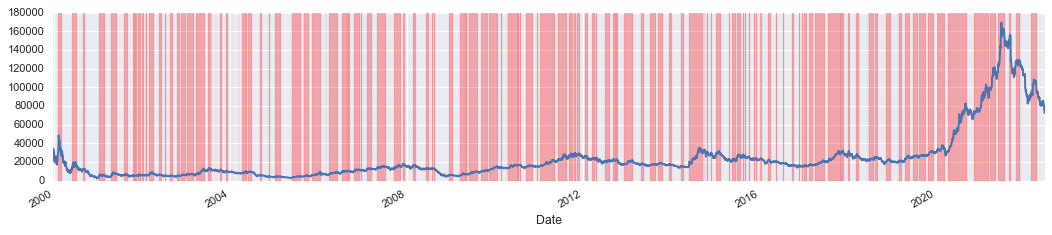

In [100]:
stock_kakao['close'].plot(figsize=(16,3))
buy_dates = stock_kakao[stock_kakao['signal']==1].index
sell_dates = stock_kakao[stock_kakao['signal']==-1].index
for buy_date, sell_date in zip(buy_dates, sell_dates):
    plt.axvspan(xmin=buy_date, xmax=sell_date, color='r', alpha=0.3)

이번에도 2022년만 확대해서 이동평균선과 함께 확인해 보겠습니다. 주가는 붉은색 굵은 선으로 함께 그렸고, 보유기간은 역시 붉은 영역으로 표시했습니다.

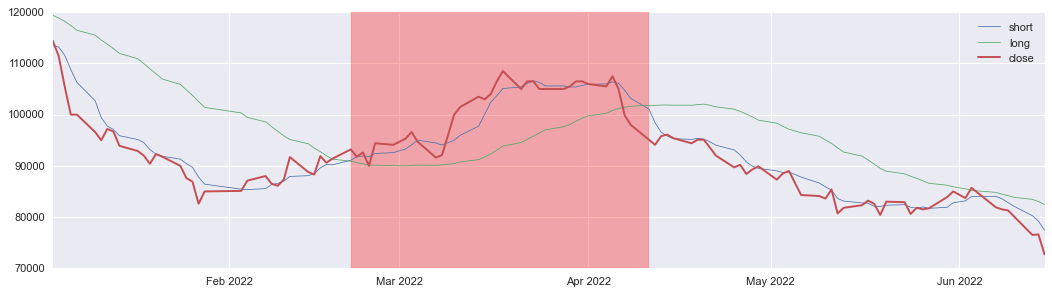

In [108]:
plt.figure(figsize=(16,4))

plt.plot(stock_kakao.loc['2022':,'short_window'], label='short', linewidth=0.7)
plt.plot(stock_kakao.loc['2022':,'long_window'], label='long', linewidth=0.7)
plt.plot(stock_kakao.loc['2022':,'close'], label='close')
buy_dates = stock_kakao.loc['2022':][stock_kakao['signal']==1].index
sell_dates = stock_kakao.loc['2022':][stock_kakao['signal']==-1].index
for buy_date, sell_date in zip(buy_dates, sell_dates):
    plt.axvspan(xmin=buy_date, xmax=sell_date, color='r', alpha=0.3)

plt.legend()
plt.show()

단순한 전략이지만 상승 기간에 잘 보유하고 있었네요.

이제 누적 수익률을 확인해 보겠습니다. 전략은 총 129회 시행(매수~매도 사이클) 되었고 시행 마다의 수익률은 다음과 같습니다. 참고로 numpy array는 누적 곱을 계산하는 cumprod() 함수를 제공하고 있습니다.

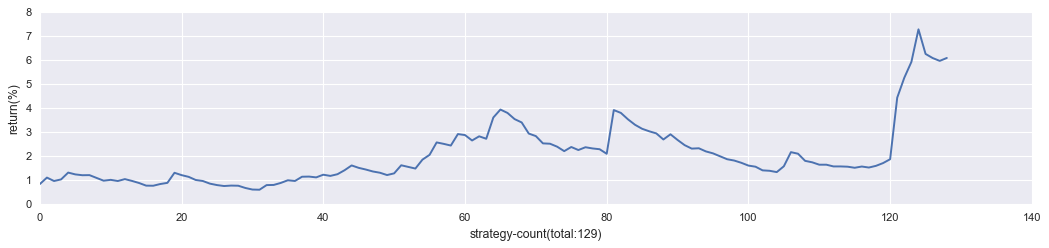

In [117]:
import numpy as np

plt.figure(figsize=(16,3))
data = (yield_array).cumprod()
sns.lineplot(x=np.arange(0,len(data),1), y=data)
plt.xlabel(f'strategy-count(total:{len(data)})')
plt.ylabel('return(%)')
plt.show()

위 수익률을 토대로 초깃값을 100만 원으로 세팅하면, 최종 수익률은 약 609만 원이 나옵니다.

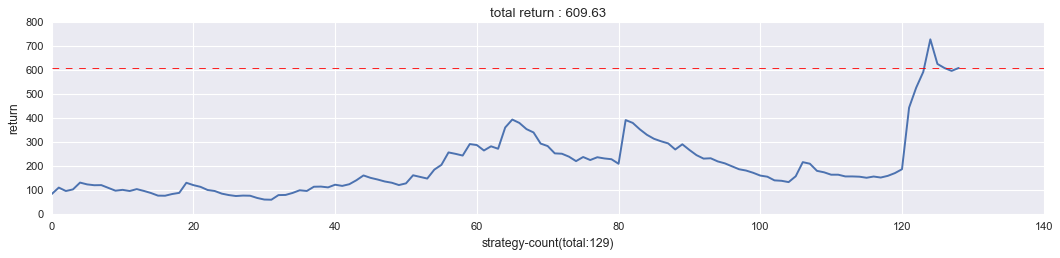

In [129]:
import numpy as np

plt.figure(figsize=(16,3))
data = 100 * (yield_array).cumprod()
sns.lineplot(x=np.arange(0,len(data),1), y=data)
plt.xlabel(f'strategy-count(total:{len(data)})')
plt.ylabel('return')
plt.title(f'total return : {data[-1]:.2f}')
plt.axhline(data[-1], color='r', linestyle='--', linewidth=0.76)
plt.show()


이렇게 오르는 추세를 포착해서 매수, 매도를 반복하는 전략을 테스트해 봤습니다. 상대적으로 손실 폭을 줄일 수는 있었으나 상승 폭 역시 상당 부분 놓쳤기 때문에 장기적으로는 단순 보유보다 좋지 못한 결과를 보였습니다. 또한  매매수수료를 고려하지 않았다는 점에서 매매가 잦은 위와 같은 전략이 더 불리하게 작용할 수 있겠습니다.

​